In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, roc_curve, roc_auc_score




In [3]:
X_train = pd.read_csv('./../1.Data/TrainTest/X_train.csv')
X_test = pd.read_csv('./../1.Data/TrainTest/X_test.csv')
y_train = pd.read_csv('./../1.Data/TrainTest/y_train.csv')
y_test = pd.read_csv('./../1.Data/TrainTest/y_test.csv')
y_train = y_train['Target']
y_test = y_test['Target']

##### I. Baseline Dummy Classifier

In [4]:
#using dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=0) # stratified
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.6211453744493393

II. Logistic Regression

In [5]:

pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)


0.9129955947136564

In [138]:
y_pred = pipe.predict(X_test)
cnf= confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       564
           1       0.92      0.85      0.88       344

    accuracy                           0.91       908
   macro avg       0.91      0.90      0.91       908
weighted avg       0.91      0.91      0.91       908



In [139]:
print('Accuracy: ', acc)
print('Confusion Matrix: \n', cnf)

Accuracy:  0.9129955947136564
Confusion Matrix: 
 [[537  27]
 [ 52 292]]


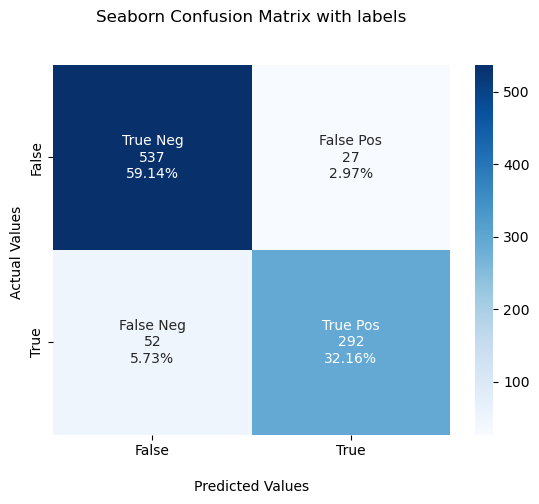

In [140]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cnf.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cnf.flatten()/np.sum(cnf)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cnf, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

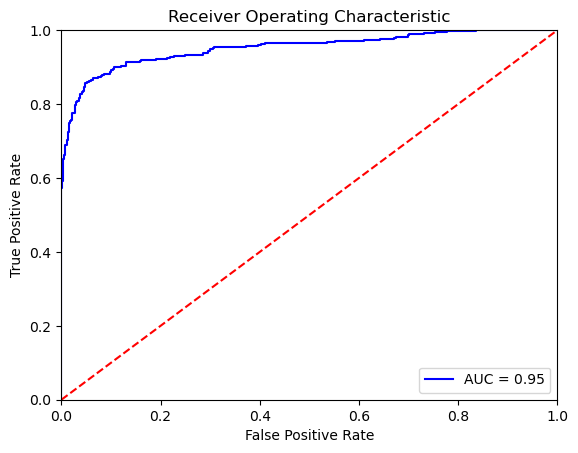

In [141]:

# calculate the fpr and tpr for all thresholds of the classification
probs = pipe.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Feature Importance and Odds Ratio:

**Feature Importance**
- Positive coefficient: As the feature value increases, the log odds of the target event increase, leading to a higher probability.
- Negative coefficient: As the feature value increases, the log odds of the target event decrease, leading to a lower probability.

**Odds Ratio** </br>
The odds ratio is the exponentiation of the coefficient.
- Odds ratio > 1: The odds of the event increase as the feature value increases.
- Odds ratio < 1: The odds of the event decrease as the feature value increases.
- Odds ratio = 1: The odds of the event are not affected by the feature.

Text(0, 0.5, 'Feature')

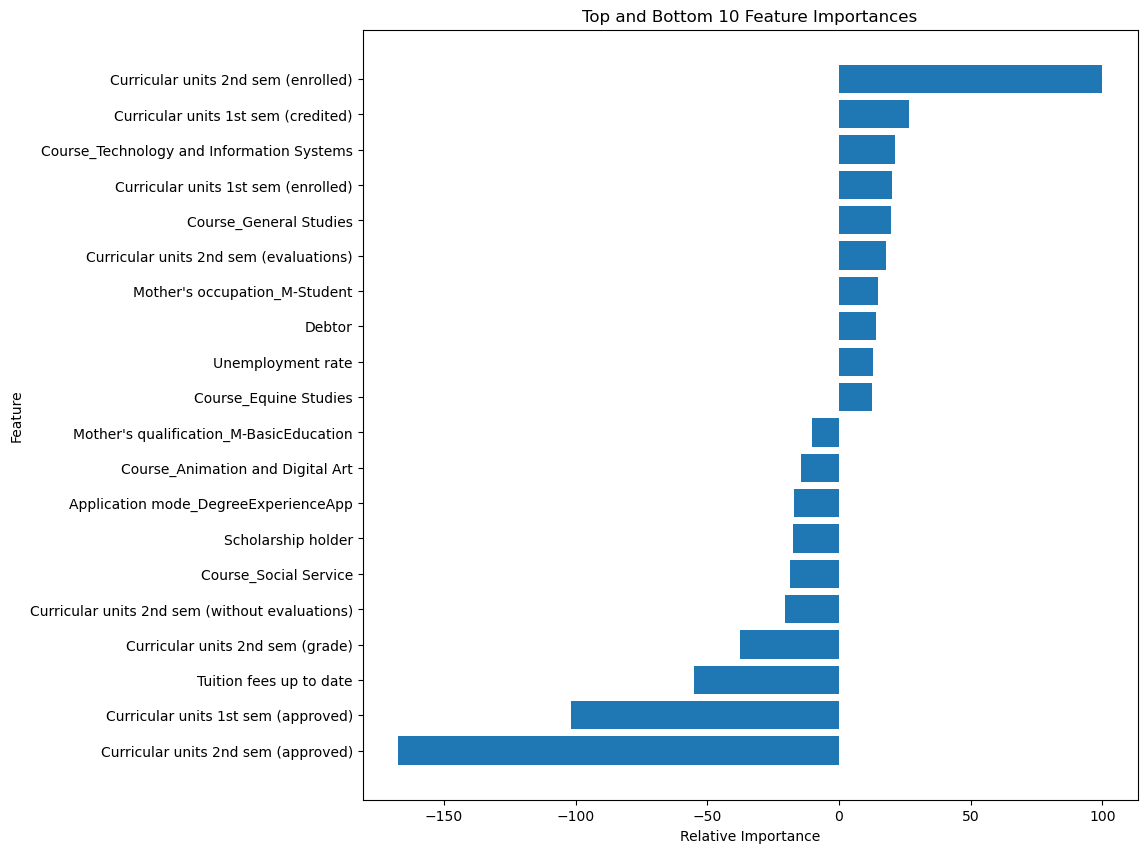

In [142]:
#Feature Importance
# Get the feature importance from the classifier
feature_importance = pipe.steps[1][1].coef_[0]

# Normalize The Features
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
# Get the top 10 and bottom 10 feature importances
top_10_feature_indexes = sorted_idx[-10:]
bottom_10_feature_indexes = sorted_idx[:10]

# Extract top and bottom features and importance values
top_10_features = np.array(X_train.columns)[top_10_feature_indexes]
top_10_importance = feature_importance[top_10_feature_indexes]
bottom_10_features = np.array(X_train.columns)[bottom_10_feature_indexes]
bottom_10_importance = feature_importance[bottom_10_feature_indexes]

#Add top 10 and bottom 10 to a dataframe
top_bottom_10_features = np.concatenate((top_10_features, bottom_10_features))
top_bottom_10_importance = np.concatenate((top_10_importance, bottom_10_importance))


# Plot the feature importances of LR Model
#sort the values in ascending order
top_bottom_10_importance, top_bottom_10_features = zip(*sorted(zip(top_bottom_10_importance, top_bottom_10_features)))
# Plot the feature importances of the forest
plt.figure(figsize=(10, 10))
plt.title("Top and Bottom 10 Feature Importances")
plt.barh(range(len(top_bottom_10_importance)), top_bottom_10_importance, align="center")
plt.yticks(range(len(top_bottom_10_importance)), top_bottom_10_features)
plt.xlabel("Relative Importance")
plt.ylabel("Feature")


#### Odds Ratio

In [143]:
#Odd Ratios
# Get Odds ratio

odd_ratio = np.exp(pipe.steps[1][1].coef_)
odd_ratio = pd.DataFrame(odd_ratio, columns=X_train.columns)
odd_ratio = odd_ratio.T
odd_ratio.columns = ['Odds Ratio']

In [144]:
odd_ratio.sort_values(by='Odds Ratio', ascending=False).head(10)

,Odds Ratio
Curricular units 2nd sem (enrolled),5.862364
Curricular units 1st sem (credited),1.601288
Course_Technology and Information Systems,1.453562
Curricular units 1st sem (enrolled),1.431009
Course_General Studies,1.419501
Curricular units 2nd sem (evaluations),1.367054
Mother's occupation_M-Student,1.297876
Debtor,1.285824
Unemployment rate,1.258804
Course_Equine Studies,1.245062


While the Odds Ratio tells you a 1 point increase in a given variable results in an increased chance of the dependent variable occuring, this isn't helpful when the features were scaled. In other words, it would be better to convert the data to an odds ratio that applies to each variable in their original scale. So, in the case of the above, a 1 point increase in curriculum units would either increase or decrease the likelihood of dropping out.

**Back Transformation for Odds Ratio in Original Scale**:
</br>
</br>

**Get the Coefficients:**
</br>
</br>
After fitting the model, obtain the coefficients (coef_) and intercept (intercept_) from the model.
</br>
</br>

**Back-Transformation:**
</br>
</br>
Use the inverse transform function of the scaler to transform the coefficients back to the original scale. The formula for back-transformation is as follows:
</br>
</br>
$$ Original Coefficient= Scaler Scale / Scaled Coefficient $$
​</br>
</br>
The scaler scale is the standard deviation of the original feature, for StandardScaler().
</br>
</br>
Calculate the Odds Ratio:
Once you have the coefficients in the original scale, calculate the odds ratio. The odds ratio for a one-unit increase in the original feature is given by:
</br>
</br>
$$ Odds Ratio = e^{Original Coefficient}\ $$


In [145]:
coef_scaled = pipe.steps[1][1].coef_ 
scaler = pipe.steps[0][1].scale_
original_coef = coef_scaled / scaler
odd_ratio = np.exp(original_coef)

In [146]:
odd_ratio = pd.DataFrame(odd_ratio, columns=X_train.columns)
odd_ratio = odd_ratio.T
odd_ratio.columns = ['Odds Ratio']

odd_ratio.sort_values(by='Odds Ratio', ascending=False).head(10)

,Odds Ratio
Father's qualification_F-TechnicalProfessional,11.401379
Course_Technology and Information Systems,8.286346
Course_General Studies,6.217685
Mother's occupation_M-Student,3.579303
Course_Equine Studies,3.407046
Mother's occupation_M-OtherMiscellaneous,2.788052
Previous qualification_S-HigherEducation,2.545084
Course_Oral Hygiene,2.312045
Debtor,2.201553
Curricular units 2nd sem (enrolled),2.191472


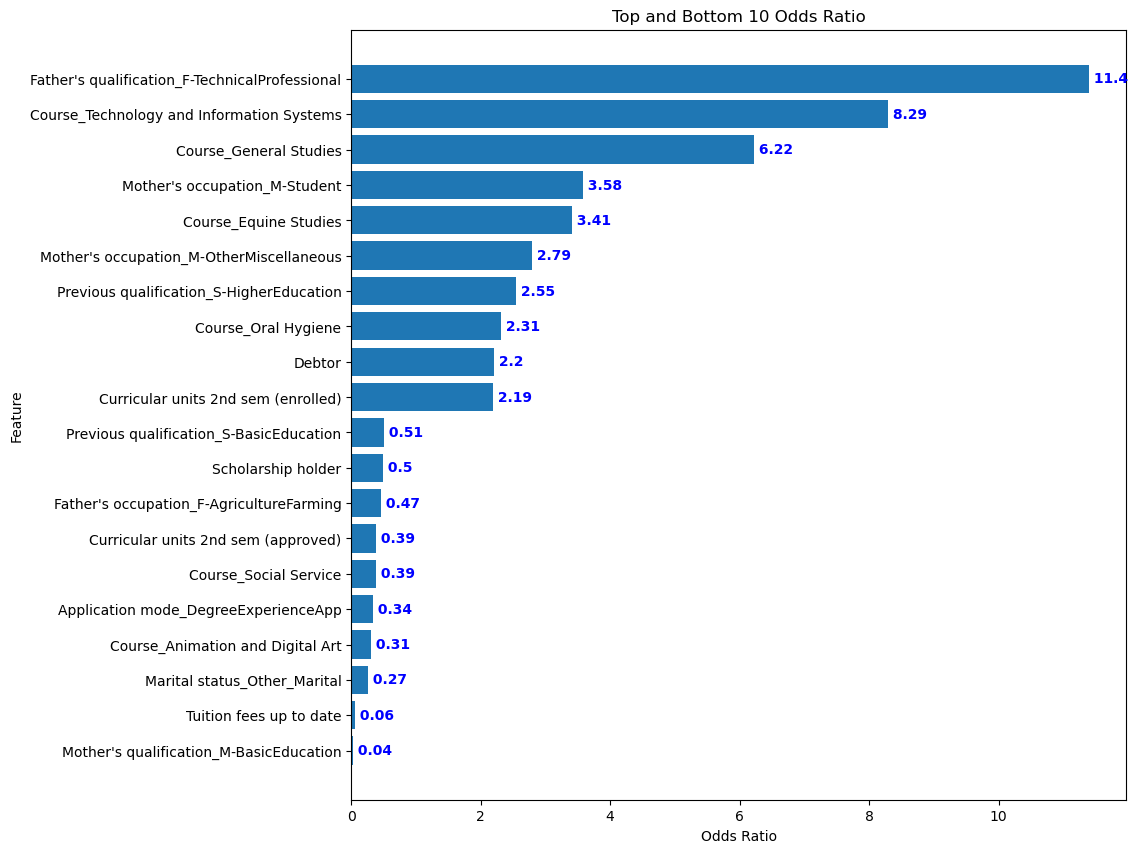

In [147]:
# Get the Top 10 Odds Ratios and the Bottom 10 (closest to 0)
top_10_features = odd_ratio.sort_values(by='Odds Ratio', ascending=False).head(10)
bottom_10_features = odd_ratio.sort_values(by='Odds Ratio', ascending=False).tail(10)
# Concatenate the top and bottom 10 features
top_bottom_10_features = pd.concat([top_10_features, bottom_10_features])
# Sort the values in ascending order
top_bottom_10_features = top_bottom_10_features.sort_values(by='Odds Ratio', ascending=True)
# Plot the top and bottom 10 features
plt.figure(figsize=(10, 10))
plt.title("Top and Bottom 10 Odds Ratio")
plt.barh(range(len(top_bottom_10_features)), top_bottom_10_features['Odds Ratio'], align="center")
plt.yticks(range(len(top_bottom_10_features)), top_bottom_10_features.index)
# add values in or on the bars
for i, v in enumerate(top_bottom_10_features['Odds Ratio']):
    plt.text(v, i, " "+str(round(v,2)), color='blue', va='center', fontweight='bold')


plt.xlabel("Odds Ratio")
plt.ylabel("Feature")
plt.show()


#### Odds Ratio Summary:

The Odds Ratio leads to some interesting associations in the model. According the model trained above, student finances and parent's education is highly associated with either graduating or dropping out. For example, presence of up to date Tuition fees dramatically reduces the probability of dropout, making it almost negligible. 
</br>
</br>

**I. Negative Relationships**
</br>

**a. Financial** </br>
Tuition fees up to date: 94% less likely to drop out. </br>
Scholarship holder: 50% less likely to drop out. </br>
Debtor: 2x more likely to drop out. </br>

**b. Educational Profile**</br>
Mother has completed Basic Education: 96% less likely to drop out. </br>
Applicant has prior degree experience: 66% less likely to drop out. </br>
Father received technical, or trade, education: 11.4x more likely to drop out </br>

**c. Enrolled Course**</br>
Tech and IT: 8.29x more likely to drop out</br> 
Equine Studies: 3.4x more likely to drop out</br>
Animation and Digital Art: 69% less likely to drop out</br>

In [148]:
## TO DO: convert the below to a clean summary markdown cell

#accuracy is defined as the number of correct predictions divided by the total number of predictions
#precision is defined as the number of true positives divided by the number of true positives plus the number of false positives. 
#recall is defined as the number of true positives divided by the number of true positives plus the number of false negatives.
#F1 score is defined as the harmonic mean of precision and recall.
#ROC curve is a plot of the true positive rate against the false positive rate for the different possible cutpoints of a diagnostic test.
#AUC is the area under the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

#Accuracy is the probability that a sample is classified correctly.
#Precision, in other words, is the probability that a sample classified as positive is actually positive.
#Recall is the probability that a positive sample is classified as positive.
#F1 score is the harmonic mean of precision and recall.
#ROC, in otherwords, is the probability that a positive sample is classified as positive and a negative sample is classified as negative.


# Precision is the probability that a predicted positive is actually positive.
# Recall is the probability that an actual positive is predicted positive.

#For example, if a model predicts that 10 emails are spam, and 5 of those emails are actually spam, then the model's precision is 50%. 
#This means that the model is correct half of the time when it predicts that an email is spam.

#For example, if there are 100 spam emails in a dataset, and a model identifies 80 of them, then the model's recall is 80%. 
#This means that the model found 80% of the actual spam emails in the dataset.

#The F1 score is a good measure to use when the cost of false positives and false negatives is the same. 
#For example, the F1 score is often used to evaluate the performance of spam filters.


In [9]:
##Next Steps: Cross-Validation to avoid overfitting
##Next Steps: Hyperparameter Tuning to improve model performance
##Next Steps: Tree Based Models to compare performance
##Next Steps: Shapley Values to explain model predictions
